# Run all Tiny CNNs

This file runs all CNNs that are 2d, with and without context features

In [1]:
# Load standard libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import sys
import importlib
import inspect
import os

# Set up the root folder to work in any case by seaching for src or .git
def find_repo_root(start_path=None, marker_dirs=('src', '.git')):
    p = os.path.abspath(start_path or os.getcwd())
    while True:
        if any(os.path.isdir(os.path.join(p, m)) for m in marker_dirs):
            return p
        parent = os.path.dirname(p)
        if parent == p:
            return None
        p = parent

repo_root = find_repo_root()

if repo_root is None:
    repo_root = "/files/pixlball" # hard coded fallback

if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
print(f"Using repo_root: {repo_root}")

# Import modules
import src.data as data
import src.model as model
import src.train as train
import src.config as config
import src.dataset as dataset
import src.evaluate as evaluate
import src.utils as utils
import src.plotfunctions as plotfunctions
import src.losses as losses

from src.config import DEVICE 


# Reloads in cases the files were changed
importlib.reload(data)
importlib.reload(train)
importlib.reload(evaluate)
importlib.reload(model)
importlib.reload(dataset)
importlib.reload(utils)
importlib.reload(plotfunctions)
importlib.reload(losses)
importlib.reload(config)

# Enforce Replicability
utils.enforce_replicability(42)

Using repo_root: /files/pixlball


In [2]:
# Load raw Data
data_events = pd.read_parquet(os.path.join(repo_root, "data", "events_data.parquet"), engine="fastparquet")
data_360 = pd.read_parquet(os.path.join(repo_root, "data", "sb360_data.parquet"), engine="fastparquet")

In [3]:
# Cleans Data and assigns nn targets
df_with_targets = data.event_data_loader(data_events)
data_events = None # save memory

# Adds the ball vector for the kinetic Model
df_with_targets = data.add_ball_trajectory_features(df_with_targets)

133039 events.
counts of each outcome nn_target
Keep Possession    635414
Lose Possession    245066
Shot                38597
Name: count, dtype: int64


## Prepare 360 Data

In [4]:
# Assigns grid cells to each frame
df_360 = data.assign_grid_cells(data_360)
data_360 = None # save memory
nn_final = data.aggregate_nn_layers_vectorized(df_360)

## Finalize Df

In [5]:
# Prepares the Baseline Dataset
nn_dataset = data.prepare_nn_dataset(df_with_targets, nn_final, target_cols=['nn_target', 'goal_flag'], context_cols = True, keep_context_ids = True ) # adjust cols depending on model

# Adds the context columns
nn_dataset = data.add_context_cols(nn_dataset)

# Turns targets into integers
nn_dataset = data.add_target_as_int(nn_dataset)

# Add the
nn_dataset, ball_vector_columns = data.add_ball_coordinates(nn_dataset)

## Weights

In [6]:
# Generate the Weights
class_weights_event, goal_pos_weight = utils.get_multitask_loss_weights(nn_dataset, DEVICE)
print(f"Goal Positive Weight (0/1 ratio): {goal_pos_weight.item():.2f}")

Calculated Event Weights: [0.4530875322204915, 0.7430756467132296, 1.8038368210662787]
Goal Pos Weight: 5.0
Goal Positive Weight (0/1 ratio): 5.00


# Prepare Datasets for CNNs

In [7]:
# Do the Train / Test Split of the data on matches
train_df, val_df = utils.perform_replicable_split(nn_dataset)

Replicable Split: 231 Train Matches, 58 Test Matches


## Run the Baseline Model

In [8]:
# Set Layer Columns
layer_columns = ["ball_layer", "teammates_layer", "opponents_layer"]

# Training Dataset extraction - Pass only the values in the correct order
train_dataset = dataset.PitchDatasetMultiTask(
    train_df[layer_columns],             # This maps to the 1st argument (features)
    train_df['nn_target_int'].values,    # This maps to the 2nd argument (events)
    train_df['goal_flag'].values         # This maps to the 3rd argument (goals)
)

# Validation Dataset extraction
validation_dataset = dataset.PitchDatasetMultiTask(
    val_df[layer_columns], 
    val_df['nn_target_int'].values, 
    val_df['goal_flag'].values
)

print(f"Total training samples: {len(train_dataset)}")
print(f"Total validation samples: {len(validation_dataset)}")
print(f"Goal Positive Weight (0/1 ratio): {goal_pos_weight.item():.2f}")


Total training samples: 643933
Total validation samples: 161667
Goal Positive Weight (0/1 ratio): 5.00


In [9]:
# Initialize the architecture from the model module
baseline_model = model.TinyCNN_MultiTask_Threat(
    config.GRID_HEIGHT, 
    config.GRID_WIDTH, 
    config.NUM_EVENT_CLASSES
)

# Setup criteria / losses
criterion_ev = losses.FocalLossThreat(alpha=class_weights_event, gamma=2.0)
criterion_gl = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([goal_pos_weight]).to(config.DEVICE))

# Load Data
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

# Train the model
baseline_model = train.train_multi_task_model(
    baseline_model, 
    train_loader, 
    criterion_ev, 
    criterion_gl,
    config.BASELINE_NUM_EPOCHS,
    "Baseline"
)

Baseline Epoch 1: 100%|██████████| 20123/20123 [01:26<00:00, 232.60it/s, ev_loss=0.2336, loss=0.9583]


In [10]:
# Create a dictionary to hold the results for the final table
final_results = {}
# Evaluate Baseline CNN
final_results['Baseline'] = evaluate.evaluate_paper_metrics(baseline_model, validation_dataset, "Baseline 2D")


--- Baseline 2D Summary ---
Overall Acc: 0.4752 | Bal. Acc: 0.6010 | Goal AUC: 0.6193
Recall -> Keep: 0.4022 | Loss: 0.6221 | Shot: 0.7787


Matrix saved to figures/baseline_event_cm.png


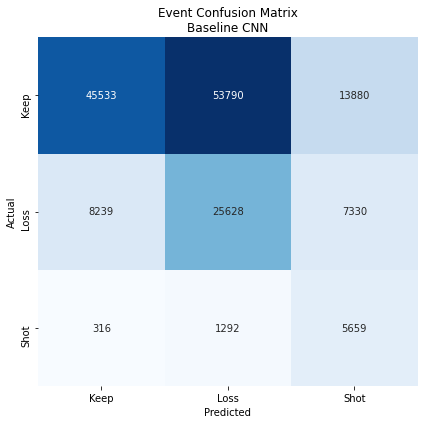

Matrix saved to figures/baseline_goal_cm.png


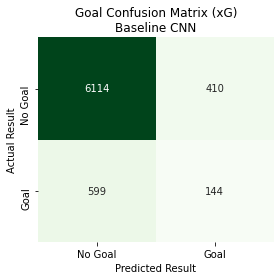

In [11]:
# Get predictions for a specific model
res = evaluate.get_predictions(baseline_model, validation_dataset)

# Extract Event Matrix
ev_cm = plotfunctions.plot_event_confusion_matrix(res['ev_targets'], res['ev_preds'], "Baseline CNN", "figures/baseline_event_cm.png")

# Extract Goal Matrix
gl_cm = plotfunctions.plot_goal_confusion_matrix(res['gl_targets'], res['gl_preds'], "Baseline CNN", "figures/baseline_goal_cm.png")

## Run the Context Model

In [12]:
context_features = ['under_pressure', 'counterpress', 'dribble_nutmeg']

# Training Dataset extraction - Pass only the values in the correct order
train_dataset_context = dataset.ContextPitchDatasetMultiTask(
    train_df[layer_columns],             # This maps to the 1st argument (features)
    train_df['nn_target_int'].values,    # This maps to the 2nd argument (events)
    train_df['goal_flag'].values,
    train_df[context_features]        # This maps to the 3rd argument (goals)
)

# Validation Dataset extraction
validation_dataset_context = dataset.ContextPitchDatasetMultiTask(
    val_df[layer_columns], 
    val_df['nn_target_int'].values, 
    val_df['goal_flag'].values,
    val_df[context_features]  
)

print(f"Total training samples: {len(train_dataset_context)}")
print(f"Total validation samples: {len(validation_dataset_context)}")

Total training samples: 643933
Total validation samples: 161667


In [14]:
# Initialize the architecture from the model module
# Calculate how many features are in your context (e.g., 8 for ball vector)
num_ctx = len(context_features)

context_model = model.TinyCNN_MultiTask_Context_Threat(
    grid_height=config.GRID_HEIGHT,
    grid_width=config.GRID_WIDTH,
    num_event_classes=config.NUM_EVENT_CLASSES,
    num_context_features=num_ctx
)

# Setup criteria / losses
criterion_ev = losses.FocalLossThreat(alpha=class_weights_event, gamma=2.0)
criterion_gl = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([goal_pos_weight]).to(config.DEVICE))

# Load Data
train_loader_ctx = DataLoader(train_dataset_context, batch_size=config.BATCH_SIZE, shuffle=True)

# Train the model
context_model = train.train_multi_task_model(
    context_model, 
    train_loader_ctx, 
    criterion_ev, 
    criterion_gl, 
    config.CONTEXT_NUM_EPOCHS,
    "Contextual-CNN"
)

Contextual-CNN Epoch 1: 100%|██████████| 20123/20123 [01:31<00:00, 220.47it/s, ev_loss=0.0925, loss=0.2911]


In [15]:
# Evaluate Context Model
final_results['Context-Situational'] = evaluate.evaluate_paper_metrics(context_model, validation_dataset_context, "Situational")


--- Situational Summary ---
Overall Acc: 0.5313 | Bal. Acc: 0.6095 | Goal AUC: 0.6272
Recall -> Keep: 0.4916 | Loss: 0.6051 | Shot: 0.7318


Matrix saved to figures/context_event_cm.png


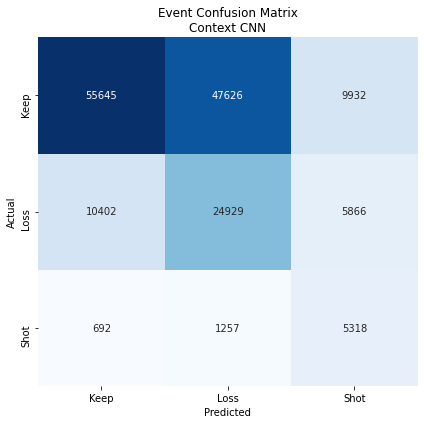

Matrix saved to figures/context_goal_cm.png


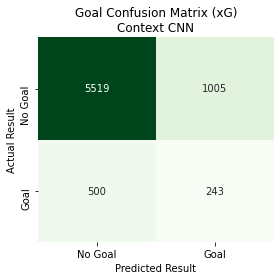

In [16]:
# Get predictions
res = evaluate.get_predictions(context_model, validation_dataset_context)

# Extract Event Matrix
ev_cm = plotfunctions.plot_event_confusion_matrix(res['ev_targets'], res['ev_preds'], "Context CNN", "figures/context_event_cm.png")

# Extract Goal Matrix
gl_cm = plotfunctions.plot_goal_confusion_matrix(res['gl_targets'], res['gl_preds'], "Context CNN", "figures/context_goal_cm.png")

## Run the Ball Vector Context Model

In [18]:
# Training Dataset extraction - Pass only the values in the correct order
train_dataset_kinetic = dataset.ContextBallVectorPitchDatasetMultiTask(
    train_df[layer_columns],             # This maps to the 1st argument (features)
    train_df['nn_target_int'].values,    # This maps to the 2nd argument (events)
    train_df['goal_flag'].values,
    train_df[ball_vector_columns]        # This maps to the 3rd argument (goals)
)

# Validation Dataset extraction
validation_dataset_kinetic = dataset.ContextBallVectorPitchDatasetMultiTask(
    val_df[layer_columns], 
    val_df['nn_target_int'].values, 
    val_df['goal_flag'].values,
    val_df[ball_vector_columns]  
)

print(f"Total training samples: {len(train_dataset_kinetic)}")
print(f"Total validation samples: {len(validation_dataset_kinetic)}")

Total training samples: 643933
Total validation samples: 161667


In [19]:
import src.model as arch
import src.losses as losses
from torch.utils.data import DataLoader

# Initialize the architecture from the model module
# Set number of features in your ball vector (e.g., 8)

kinetic_model = arch.TinyCNN_MultiTask_Context_Threat(
    grid_height=config.GRID_HEIGHT,
    grid_width=config.GRID_WIDTH,
    num_event_classes=config.NUM_EVENT_CLASSES,
    num_context_features=len(ball_vector_columns)
)

# Setup criteria / losses
criterion_ev = losses.FocalLossThreat(alpha=class_weights_event, gamma=2.0)
criterion_gl = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([goal_pos_weight]).to(config.DEVICE))

# # Load Data
train_loader_kin = DataLoader(train_dataset_kinetic, batch_size=config.BATCH_SIZE, shuffle=True)

# Train the model
kinetic_model = train.train_multi_task_model(
    kinetic_model, 
    train_loader_kin, 
    criterion_ev, 
    criterion_gl,
    config.KINETIC_NUM_EPOCHS,
    "Kinetic-Vector-CNN"
)

Kinetic-Vector-CNN Epoch 1: 100%|██████████| 20123/20123 [01:43<00:00, 193.50it/s, ev_loss=0.1113, loss=2.8493]


In [20]:
# Evaluate Kinetic Model
final_results['Context-Kinetic'] = evaluate.evaluate_paper_metrics(kinetic_model, validation_dataset_kinetic, "Kinetic")


--- Kinetic Summary ---
Overall Acc: 0.5101 | Bal. Acc: 0.6123 | Goal AUC: 0.6134
Recall -> Keep: 0.4558 | Loss: 0.6141 | Shot: 0.7669


Matrix saved to figures/kinetic_event_cm.png


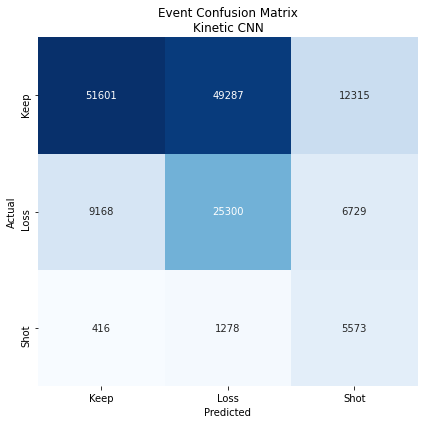

Matrix saved to figures/kinetic_goal_cm.png


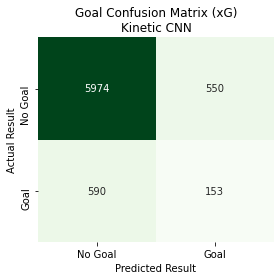

In [21]:
# Get predictions
res = evaluate.get_predictions(kinetic_model, validation_dataset_kinetic)

# Extract Event Matrix
ev_cm = plotfunctions.plot_event_confusion_matrix(res['ev_targets'], res['ev_preds'], "Kinetic CNN", "figures/kinetic_event_cm.png")

# Extract Goal Matrix
gl_cm = plotfunctions.plot_goal_confusion_matrix(res['gl_targets'], res['gl_preds'], "Kinetic CNN", "figures/kinetic_goal_cm.png")

# Run 3D CNN

In [22]:
# Generate the 4D Voxels (Channels, Time, Height, Width)
# Lookback 3 = 4 frames total (t, t-1, t-2, t-3)
voxels_list = data.generate_temporal_voxels(nn_dataset, lookback=3)

# Add as a column
nn_dataset['temporal_voxel'] = voxels_list

train_df, test_df = utils.perform_replicable_split(nn_dataset)

Replicable Split: 231 Train Matches, 58 Test Matches


In [23]:
train_dataset_3d = dataset.VoxelPitchDataset(train_df)
test_dataset_3d = dataset.VoxelPitchDataset(test_df)

#Check the shape of the first item
#voxel, event, goal = train_dataset_3d[0]
#print(f"Voxel Shape: {voxel.shape}")

In [24]:
# Manually set weights for the 3D Model
class_weights_event = torch.tensor(config.VOXEL_WEIGHTS, dtype=torch.float32).to(config.DEVICE)

In [25]:
# Initialize the architecture from the model module
voxel_model = model.Tiny3DCNN_MultiTask(
    num_event_classes=config.NUM_EVENT_CLASSES
)

# Setup criteria / losses
criterion_ev = losses.FocalLossThreat(alpha=class_weights_event, gamma=2.0)
criterion_gl = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([goal_pos_weight]).to(config.DEVICE))

# Load Data
train_loader_3d = DataLoader(train_dataset_3d, batch_size=config.BATCH_SIZE, shuffle=True)

# Train the model
voxel_model = train.train_multi_task_model(
    voxel_model, 
    train_loader_3d, 
    criterion_ev, 
    criterion_gl, 
    config.VOXEL_NUM_EPOCHS,
    "3D-Voxel-CNN",
    lr = config.LR_3D
)

3D-Voxel-CNN Epoch 1: 100%|██████████| 20123/20123 [02:15<00:00, 148.23it/s, ev_loss=0.7910, loss=1.0737]


# Evaluation

In [26]:
# Evaluate 3D CNN
final_results['3D-Voxel'] = evaluate.evaluate_paper_metrics(voxel_model, test_dataset_3d, "3D CNN")


--- 3D CNN Summary ---
Overall Acc: 0.4732 | Bal. Acc: 0.3339 | Goal AUC: 0.5278
Recall -> Keep: 0.5712 | Loss: 0.2567 | Shot: 0.1738


Matrix saved to figures/voxel_event_cm.png


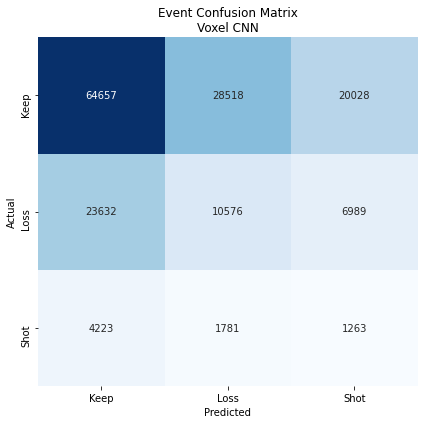

Matrix saved to figures/voxel_goal_cm.png


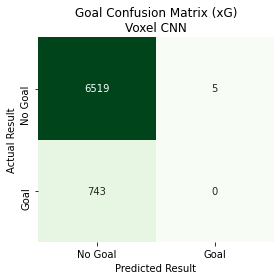

In [27]:
# Get predictions
res = evaluate.get_predictions(voxel_model, test_dataset_3d)

# Extract Event Matrix
ev_cm = plotfunctions.plot_event_confusion_matrix(res['ev_targets'], res['ev_preds'], "Voxel CNN", "figures/voxel_event_cm.png")

# Extract Goal Matrix
gl_cm = plotfunctions.plot_goal_confusion_matrix(res['gl_targets'], res['gl_preds'], "Voxel CNN", "figures/voxel_goal_cm.png")

# Combined Results

In [28]:
# Now convert the storage of results into a Dataframe
df_results = pd.DataFrame(final_results).T

# Reorder columns for the paper
columns_order = ["Accuracy", "Balanced Acc", "Recall_Keep", "Recall_Loss", "Recall_Shot", "Goal AUC"]
df_results = df_results[columns_order]

df_results.to_csv("model_comparison_table.csv", index=False)

print("\nFINAL UTILITY COMPARISON TABLE")
print(df_results)


FINAL UTILITY COMPARISON TABLE
                     Accuracy  Balanced Acc  Recall_Keep  Recall_Loss  \
Baseline             0.475174      0.601011     0.402224     0.622084   
Context-Situational  0.531290      0.609490     0.491551     0.605117   
Context-Kinetic      0.510147      0.612280     0.455827     0.614122   
3D-Voxel             0.473170      0.333892     0.571160     0.256718   

                     Recall_Shot  Goal AUC  
Baseline                0.778726  0.619287  
Context-Situational     0.731801  0.627248  
Context-Kinetic         0.766891  0.613449  
3D-Voxel                0.173799  0.527813  


# Plots of inputs

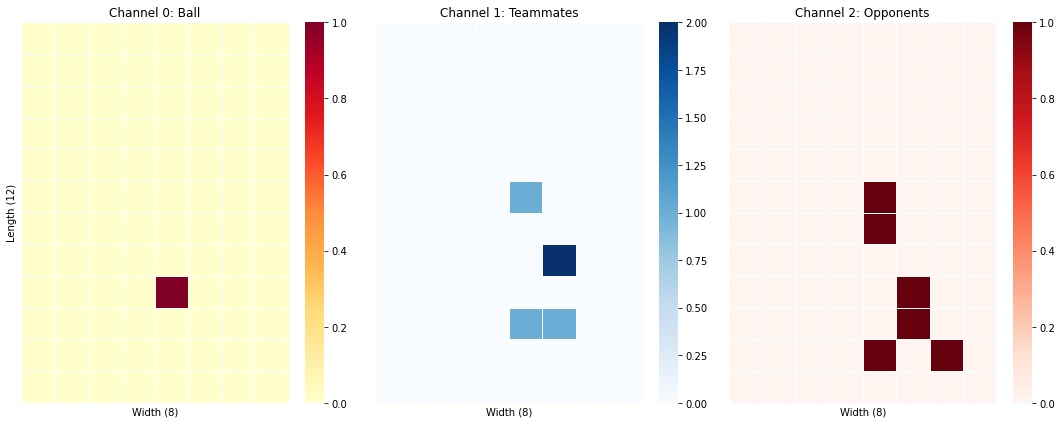

In [29]:
# This saves the 2d Channel plot for the paper
plotfunctions.plot_2d_channels_separated(train_dataset, save_path="figures/channel_visualization.png")